In [1]:
# set conda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

# install psi4
!conda install -q -y psi4 python=3.7 -c psi4

# install rdkit
!conda install -q -y rdkit python=3.7 -c rdkit

# set path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/")

# this command is needed to avoid "Loader" error.
!pip install distributed

--2022-04-24 09:46:24--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-04-24 09:46:24--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75660608 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  72.16M   182MB/s    in 0.4s    

2022-04-24 09:46:24 (182 MB/s) - ‘Miniconda3-latest-Linux

In [2]:
# import Psi4
import psi4
# check Psi4 version
print(psi4.__version__)

1.5


In [3]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole
# check rdkit version
print('rdkit version: ', rdBase.rdkitVersion)

rdkit version:  2020.09.1


In [4]:
## convert SMILES to xyz format
def smi2xyz(smiles):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles)) # make mol object and add Hydrogen
    AllChem.EmbedMolecule(mol, AllChem.ETKDGv3()) # expand to 3D
    AllChem.MMFFOptimizeMolecule(mol) # structure optimization by MMFF
    #xyz = Chem.MolToXYZBlock(mol)
    conf = mol.GetConformer(-1)

    plus = smiles.count('+')
    minus = smiles.count('-')
    charge = plus - minus + 0 # total charge
    
    multi = (charge%2) + 1 # 2S+1 = 2*((1/2)*(charge%2)) + 1 (low spin)
    
    xyz = str(charge) + " " + str(multi)
    for atom, (x,y,z) in zip(mol.GetAtoms(), conf.GetPositions()):
        xyz += '\n'
        xyz += '{} {} {} {}'.format(atom.GetSymbol(), x, y, z)
        #xyz += '{}\t{}\t{}\t{}'.format(atom.GetSymbol(), x, y, z)
        
    return xyz

In [5]:
!pip install py3Dmol

In [6]:
import py3Dmol
print(py3Dmol.__version__)

1.8.0


In [7]:
#view = py3Dmol.view(query='cid:5785', viewergrid=(1,2))
#view.setStyle({'stick': {}}, viewer=(0,0))
#view.setStyle({'sphere': {}}, viewer=(0,1))
#view.show()

In [8]:
xyz = smi2xyz('CC(OC1=C(C(=O)O)C=CC=C1)=O')
mol = psi4.geometry(xyz)
print(mol.save_string_xyz())

0 1
 C    3.468393625378    0.338847578153    0.113704502430
 C    2.096953611336   -0.151635837772    0.469765256936
 O    1.368841573518   -0.339842731481   -0.699802680192
 C    0.043744500354   -0.711115787138   -0.453647367820
 C   -0.952427774294    0.233812696803   -0.168192766634
 C   -0.627953903025    1.682966599503   -0.098136508635
 O    0.444847203359    2.207945459354   -0.332786105237
 O   -1.686577301593    2.432012864913    0.266686569332
 C   -2.264795310203   -0.220396558686    0.036012124926
 C   -2.568615580605   -1.582577319811   -0.058305885234
 C   -1.568498620648   -2.505448304219   -0.362772191962
 C   -0.260182068630   -2.071645257763   -0.567428867338
 O    1.713246545140   -0.365268944957    1.612670344283
 H    3.394174829187    1.265313036198   -0.461331542768
 H    4.027745801965    0.545732904038    1.030543006463
 H    3.998837433768   -0.427511776429   -0.456651436259
 H   -1.329789559232    3.344678340377    0.287891541989
 H   -3.064879038301    0.4

In [9]:
def drawPsi4Geom(mol):
    xyz = mol.save_string_xyz_file() 
    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz, "xyz")
    view.setStyle({'stick':{}})
    view.zoomTo()
    return(view.show())

drawPsi4Geom(mol)

#mol = psi4.geometry("pubchem:2244")
#drawPsi4Geom(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
psi4.core.set_output_file("log.txt")

psi4.set_memory('10GB')
psi4.set_num_threads(2)

level = 'B3LYP-D3BJ/6-311G(d,p)'

scf_e, wfn = psi4.energy(level, return_wfn = True)
print('energy at the {} level of theory:\t{:.4f}'.format(level, scf_e))

energy at the B3LYP-D3BJ/6-311G(d,p) level of theory:	-648.9078


In [11]:
print(round(scf_e,3),'a.u.')

LUMO_idx = wfn.nalpha()
HOMO_idx = LUMO_idx - 1
homo = wfn.epsilon_a_subset("AO", "ALL").np[HOMO_idx]
lumo = wfn.epsilon_a_subset("AO", "ALL").np[LUMO_idx]
print('homo:',round(homo,5),' a.u.')
print('lumo:',round(lumo,5),' a.u.')

-648.908 a.u.
homo: -0.26751  a.u.
lumo: -0.06448  a.u.


In [12]:
psi4.oeprop(wfn, 'WIBERG_LOWDIN_INDICES')
!cat log.txt


  Memory set to   9.313 GiB by Python driver.
  Threads set to 2 by Python driver.

Scratch directory: /tmp/

Scratch directory: /tmp/

*** tstart() called on b8da38bc9bd4
*** at Sun Apr 24 09:49:48 2022

   => Loading Basis Set <=

    Name: 6-311G(D,P)
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2, 4-6, 9-12 entry C          line   113 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 
    atoms 3, 7-8, 13     entry O          line   151 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 
    atoms 14-21          entry H          line    32 file /usr/local/share/psi4/basis/6-311g_d_p_.gbs 

   => B3LYP-D3(BJ): Empirical Dispersion <=

    Grimme's -D3 (BJ-damping) Dispersion Correction
    Grimme S.; Ehrlich S.; Goerigk L. (2011), J. Comput. Chem., 32: 1456

        s6 =       1.000000
        s8 =       1.988900
        a1 =       0.398100
        a2 =       4.421100


         ---------------------------------------------------------
                                   SCF
      

In [13]:
import numpy as np
psi4.oeprop(wfn,'DIPOLE')
dipole_vec = psi4.variable('scf dipole')
dipole = np.sqrt(np.sum(dipole_vec ** 2))
print(f'{dipole:.3f} [D]')

0.756 [D]


In [14]:
level = 'B3LYP-D3BJ/STO-3G' # Mulliken charge
scf_e, wfn = psi4.energy(level, return_wfn = True)

In [15]:
import pandas as pd
df = pd.DataFrame()
psi4.oeprop(wfn, 'MULLIKEN_CHARGES')
df[level] = np.array(wfn.atomic_point_charges())
rdkit_aspirin = Chem.AddHs(Chem.MolFromSmiles('CC(OC1=C(C(=O)O)C=CC=C1)=O CC(=O)OC1C=CC=CC=1C(O)=O'))
#mulliken = np.array(wfn.atomic_point_charges())
atms = []
for i, atom in enumerate(rdkit_aspirin.GetAtoms()):
  atms.append(atom.GetSymbol())
  #print(atom.GetSymbol(),round(df[level][i],4))
  #print(atom.GetSymbol(),round(mulliken[i],4))
df['atomic symbol'] = atms
#chg = []
#for i, atom in enumerate(rdkit_aspirin.GetAtoms()):
#  chg.append(round(df[level][i],4))
#df['charge'] = chg
df

,B3LYP-D3BJ/STO-3G,atomic symbol
0,-0.250303,C
1,0.248598,C
2,-0.176794,O
3,0.106314,C
4,-0.031586,C
5,0.231011,C
6,-0.241533,O
7,-0.247459,O
8,-0.067816,C
9,-0.079965,C


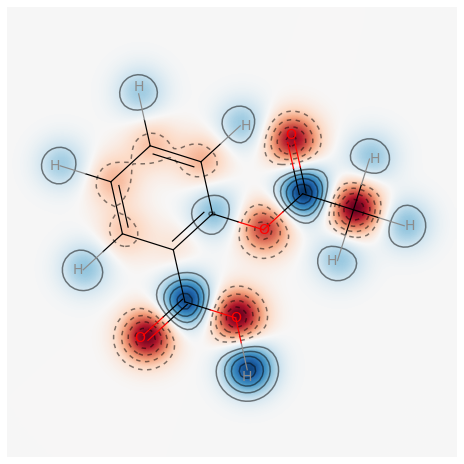

In [16]:
## Visualization with similarity map
from rdkit.Chem.Draw import SimilarityMaps
fig = SimilarityMaps.GetSimilarityMapFromWeights(rdkit_aspirin, df[level], colorMap='RdBu')
#fig = SimilarityMaps.GetSimilarityMapFromWeights(rdkit_aspirin, mulliken, colorMap='RdBu')

In [17]:
psi4.cubeprop(wfn)

def load_orbital(orbital_number: int):
    file_a = f'Psi_a_{orbital_number}_{orbital_number}-A.cube'
    file_b = f'Psi_b_{orbital_number}_{orbital_number}-A.cube'

    with open(file_a, 'r') as f:
        orbital_a = f.read()
    with open(file_b, 'r') as f:
        orbital_b = f.read()
    
    return (orbital_a, orbital_b)


with open('geom.xyz', 'r') as f:
    geom = f.read()

In [18]:
homo_a, homo_b = load_orbital(28) # this is test
lumo_a, lumo_b = load_orbital(29) # this is test

In [ ]:
view = py3Dmol.view()
view.addModel(geom, 'xyz')
view.addVolumetricData(homo_a, 'cube', {'isoval': 0.003, 'color': 'red', 'opacity': 0.6})
#view.addVolumetricData(homo_b, 'cube', {'isoval': -0.003, 'color': 'blue', 'opacity': 0.6})
view.setStyle({'stick': {}})
view.setBackgroundColor('#e1e1e1')
view.zoomTo()
view.show()

In [20]:
psi4.set_options({'cubeprop_tasks': ['esp']})
print('##\tcubeprop computation\t##')
psi4.cubeprop(wfn)

##	cubeprop computation	##


In [21]:
def load_esp_and_dt():
  file_esp = f'ESP.cube'
  file_dt  = f'Dt.cube'
  with open(file_esp, 'r') as f:
    esp_data = f.read()
  with open(file_dt, 'r') as f:
    dt_data = f.read()
  return (esp_data, dt_data)

esp, dtd = load_esp_and_dt() 

In [ ]:
view = py3Dmol.view()
view.addModel(geom, 'xyz')
view.addVolumetricData(esp,'cube', {'isoval': 0.03, 'color': 'red', 'opacity': 0.6})
#view.addVolumetricData(dtd,'cube', {'isoval': -0.03, 'color': 'blue', 'opacity': 0.6})
view.setStyle({'stick': {}})
view.setBackgroundColor('#e1e1e1')
view.zoomTo()
view.show()